In [15]:

from models.content_encoder import XLSR_ESPEAK_CTC
from models.pitch_encoder import YINEncoder
from models import DDDMPreprocessor
import util
import torch
from data import AudioDataloader, MSPPodcast, MelTransform
from config import load_hydra_config

from models.style_encoder import (
    StyleEncoder,
    ECAPA_TDNN,
    ECAPA2,
    ECAPA_TDNN_NEMO,
    WavLM_Odyssey, WavLM_Large
)
from util import get_root_path

cfg = load_hydra_config("evc_xlsr_yin", overrides=["data.dataset.segment_size=38000"])

rdm_spk_ids = torch.randint(0, 1459, (60,)).long().tolist()  # 100 random speaker
dataset = MSPPodcast(
    cfg.data,
    split="train",
    random_segmentation=True,
    label_filter={"SpkrID": rdm_spk_ids}
)
dataloader = AudioDataloader(
    dataset=dataset,
    cfg=cfg.data.dataloader,
    batch_size=32,
    shuffle=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocessor = DDDMPreprocessor(
    mel_transform=MelTransform(cfg.data.mel_transform),
    pitch_encoder=YINEncoder(cfg.model.pitch_encoder),
    content_encoder=XLSR_ESPEAK_CTC(
        return_logits=False,
        return_hidden=True,
    ),
    sample_rate=cfg.data.dataset.sampling_rate,
    perturb_inputs=False,
).to(device)
preprocessor.eval()

style_encoder = StyleEncoder(
    cfg.model.style_encoder,
).to(device)
style_encoder.eval()

util.load_model(
    style_encoder.speaker_encoder,
    "metastylespeech.pth",
    mode="eval",
    freeze=True,
)

speaker_encoder = {
    # "ECAPA_TDNN": ECAPA_TDNN(),
    # "ECAPA2": ECAPA2(),
    # "ECAPA_TDNN_NEMO": ECAPA_TDNN_NEMO(),
    # "MetaStyleSpeech": style_encoder.speaker_encoder,
    "WavLM_Large": WavLM_Large(),
}
emotion_encoder = {
    "WavLM_Odyssey": WavLM_Odyssey(),
    # "Wav2Vec2": style_encoder.emotion_encoder,
}
print("Loading models done.")

Loading models done.


In [16]:
from collections import defaultdict
import numpy as np


_spk_embeds = defaultdict(list)
_emo_embeds = defaultdict(list)
_spk_labels = []
_emo_labels = []


max_batches = min(100, len(dataloader))
with torch.no_grad():
    for j, batch in enumerate(dataloader):
        if j >= max_batches:
            break
        print(f"\rProcessing batch {j + 1}/{max_batches}", end="")
        audio, n_frames, labels = (
            batch[0].to(device, non_blocking=True),
            batch[1].to(device, non_blocking=True),
            batch[2].to(device, non_blocking=True),
        )
        x = preprocessor(audio, n_frames, labels)

        for name, model in speaker_encoder.items():
            model = model.eval().to(device)
            if name == "MetaStyleSpeech":
                # requires mel spectrogram
                spk = model(x)
            else:
                spk = model(audio)
            _spk_embeds[name].append(spk.cpu().numpy())

        for name, model in emotion_encoder.items():
            model = model.eval().to(device)
            emo = model(audio)
            _emo_embeds[name].append(emo.cpu().numpy())

        _spk_labels.append(x.label.spk_id.cpu().numpy())
        _emo_labels.append(x.label.label_tensor[:, 0:3].cpu().numpy())

Processing batch 37/37

In [18]:
# Concatenate all embeddings and labels
spk_embeds = {k: np.concatenate(v, axis=0) for k, v in _spk_embeds.items()}
emo_embeds = {k: np.concatenate(v, axis=0) for k, v in _emo_embeds.items()}
emo_labels = np.concatenate(_emo_labels, axis=0)
spk_labels = np.concatenate(_spk_labels, axis=0)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from util import get_root_path
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor


def nn_regression(emb, labels):
    E_std = StandardScaler().fit_transform(emb)

    # 2 -- 5-NN regressor, distance-weighted                                 (85%)
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance')

    # 3 -- 5-fold CV predictions                                             (90%)
    cv   = KFold(n_splits=5, shuffle=True, random_state=0)
    return cross_val_predict(knn, E_std, labels, cv=cv)

def ccc(x: np.ndarray, y: np.ndarray) -> float:
    """Lin’s concordance correlation coefficient (−1…1)."""
    vx, vy = x.var(), y.var()
    sx, sy = x.mean(), y.mean()
    r = pearsonr(x, y)[0]
    return 2 * r * np.sqrt(vx * vy) / (vx + vy + (sx - sy) ** 2 + 1e-9)

def plot_tsne(emb, name=None):
    known_spk_mask = np.where(spk_labels != -1)[0]

    X = StandardScaler().fit_transform(emb)

    tsne = TSNE(n_components=2, perplexity=40, init='pca',
                learning_rate='auto', random_state=0, angle=0.6, n_jobs=4)
    X2d = tsne.fit_transform(X)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    if name:
        fig.suptitle(f"t-SNE of {name} embeddings", fontsize=16)
    else:
        fig.suptitle("t-SNE of embeddings", fontsize=16)

    axes[0, 0].scatter(X2d[known_spk_mask,0], X2d[known_spk_mask,1], c=spk_labels[known_spk_mask], cmap='gist_ncar', s=10)  # speakers
    axes[0, 0].set_title('t‑SNE – coloured by speaker')
    axes[0, 0].set_xticks([])
    axes[0, 0].set_yticks([])

    print('Silhouette (speaker):          ', silhouette_score(X[known_spk_mask], spk_labels[known_spk_mask]))
    print('Calinski‑Harabasz (speaker):   ', calinski_harabasz_score(X[known_spk_mask], spk_labels[known_spk_mask]))
    print('Davies‑Bouldin  (speaker):     ', davies_bouldin_score(X[known_spk_mask], spk_labels[known_spk_mask]))

    emo_pred = nn_regression(emb, emo_labels)
    for i, emo in enumerate(["valence", "arousal", "dominance"]):
        row, col = divmod(i+1, 2)
        axes[row, col].scatter(X2d[:,0], X2d[:,1], c=emo_labels[:, i], cmap='plasma', s=10)  # emotions
        axes[row, col].set_title(f't‑SNE – coloured by {emo}')
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

        y_true, y_pred = emo_labels[:, i], emo_pred[:, i]
        mae = mean_absolute_error(y_true, y_pred)                       # (95%)
        r   = pearsonr(y_true, y_pred)[0]                               # (90%)
        c   = ccc(y_true, y_pred)                                       # (85%)

        print(f"{name:9s} ({emo}): MAE={mae:.4f} | CCC={c:.3f} | Pearson r={r:.3f}")
        print(f'ARI speaker vs {emo} labels: ', adjusted_rand_score(spk_labels[known_spk_mask], emo_labels[known_spk_mask, i]))

    plt.tight_layout()

    # save as svg
    plt.savefig(get_root_path() / f"img/tsne_{name}_{emb.shape[1]}.svg", format="svg", dpi=300)
    plt.savefig(get_root_path() / f"img/tsne_{name}_{emb.shape[1]}.png", format="png", dpi=300)
    plt.show()

Silhouette (speaker):           -0.056933552
Calinski‑Harabasz (speaker):    4.538148412283005
Davies‑Bouldin  (speaker):      3.227033384837042
WavLM_Large (valence): MAE=0.0962 | CCC=0.359 | Pearson r=0.416
ARI speaker vs valence labels:  0.007817851398723643
WavLM_Large (arousal): MAE=0.1024 | CCC=0.191 | Pearson r=0.230
ARI speaker vs arousal labels:  0.003487498676886016
WavLM_Large (dominance): MAE=0.0898 | CCC=0.176 | Pearson r=0.217
ARI speaker vs dominance labels:  0.009534659283818513


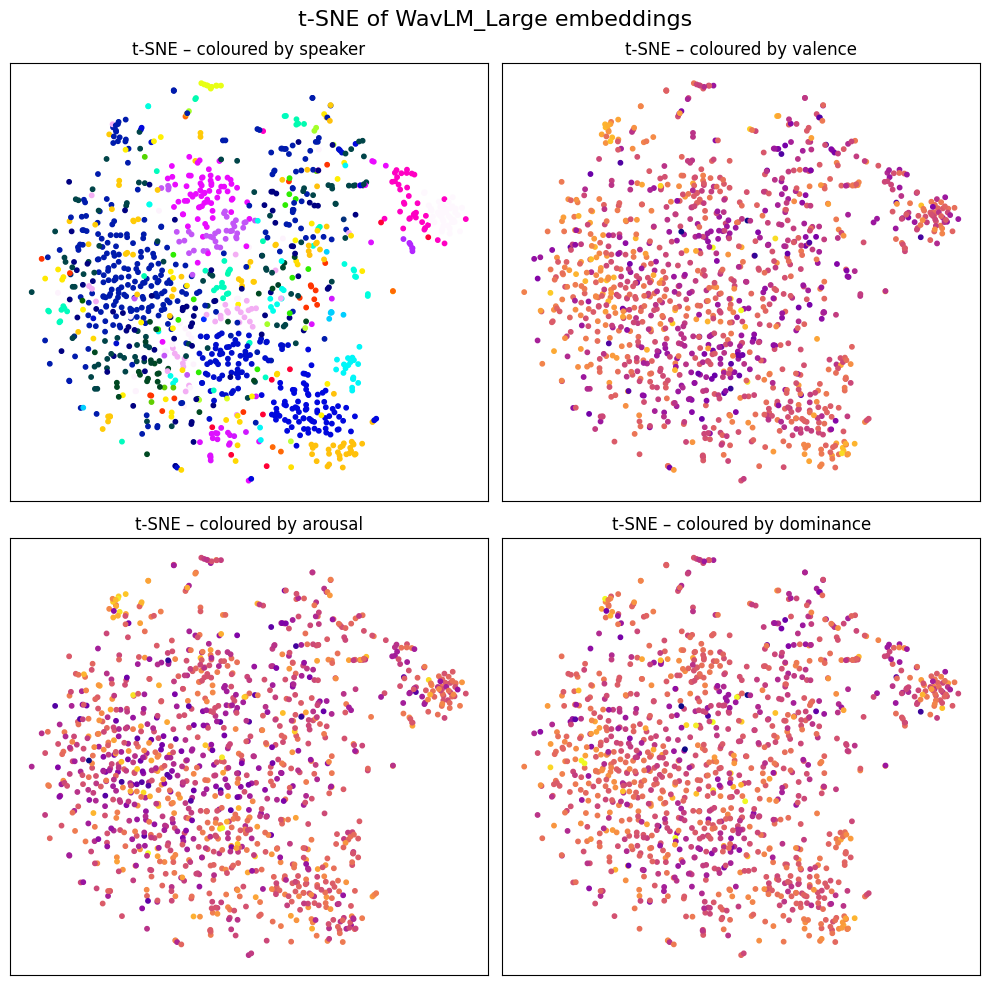

In [20]:
_emb = spk_embeds["WavLM_Large"].mean(axis=1)
plot_tsne(_emb, "WavLM_Large")

Silhouette (speaker):           0.0490506
Calinski‑Harabasz (speaker):    3.389469439425987
Davies‑Bouldin  (speaker):      1.3974057736111634
ECAPA_TDNN (valence): MAE=0.1024 | CCC=0.287 | Pearson r=0.341
ECAPA_TDNN (arousal): MAE=0.1050 | CCC=0.269 | Pearson r=0.310
ECAPA_TDNN (dominance): MAE=0.0912 | CCC=0.270 | Pearson r=0.324


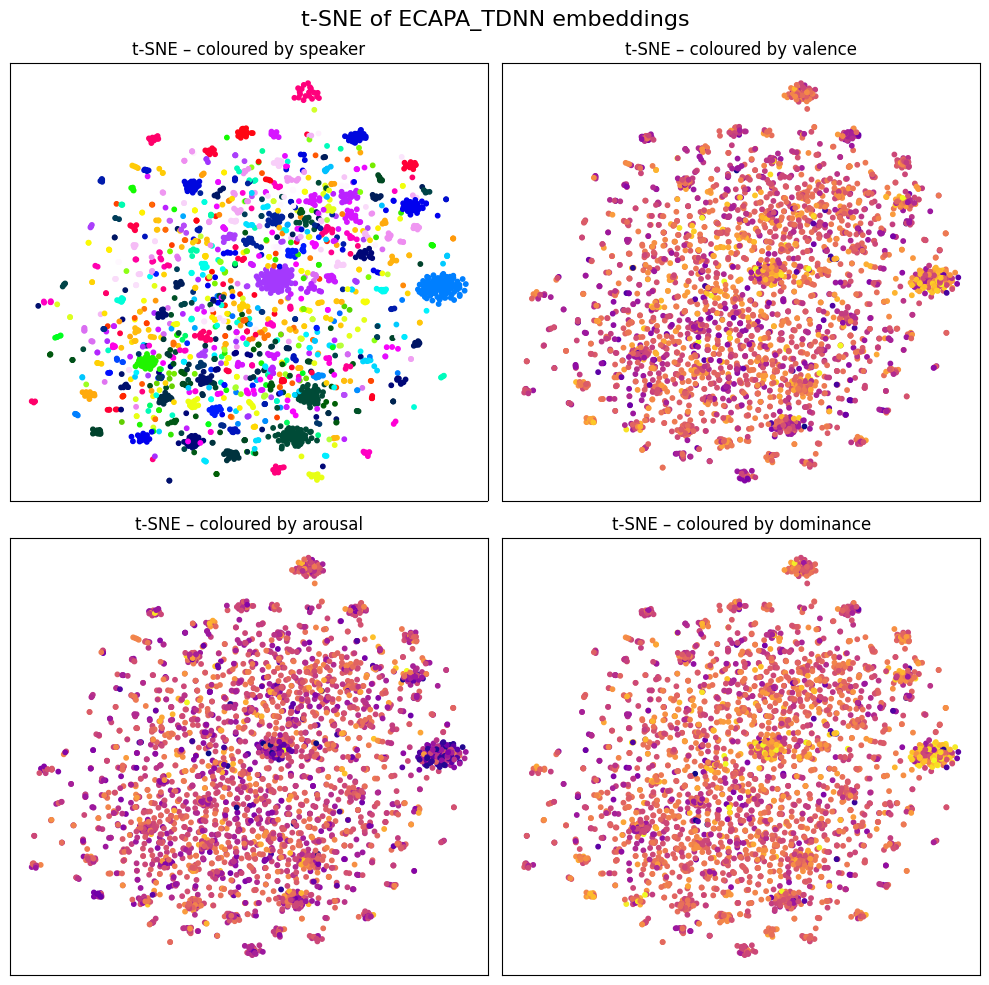

In [8]:
plot_tsne(spk_embeds["ECAPA_TDNN"], "ECAPA_TDNN")

Silhouette (speaker):           0.09682121196053553
Calinski‑Harabasz (speaker):    4.724444106443085
Davies‑Bouldin  (speaker):      1.2456146007453917
ECAPA2    (valence): MAE=0.1032 | CCC=0.285 | Pearson r=0.333
ECAPA2    (arousal): MAE=0.1052 | CCC=0.260 | Pearson r=0.301
ECAPA2    (dominance): MAE=0.0919 | CCC=0.269 | Pearson r=0.314


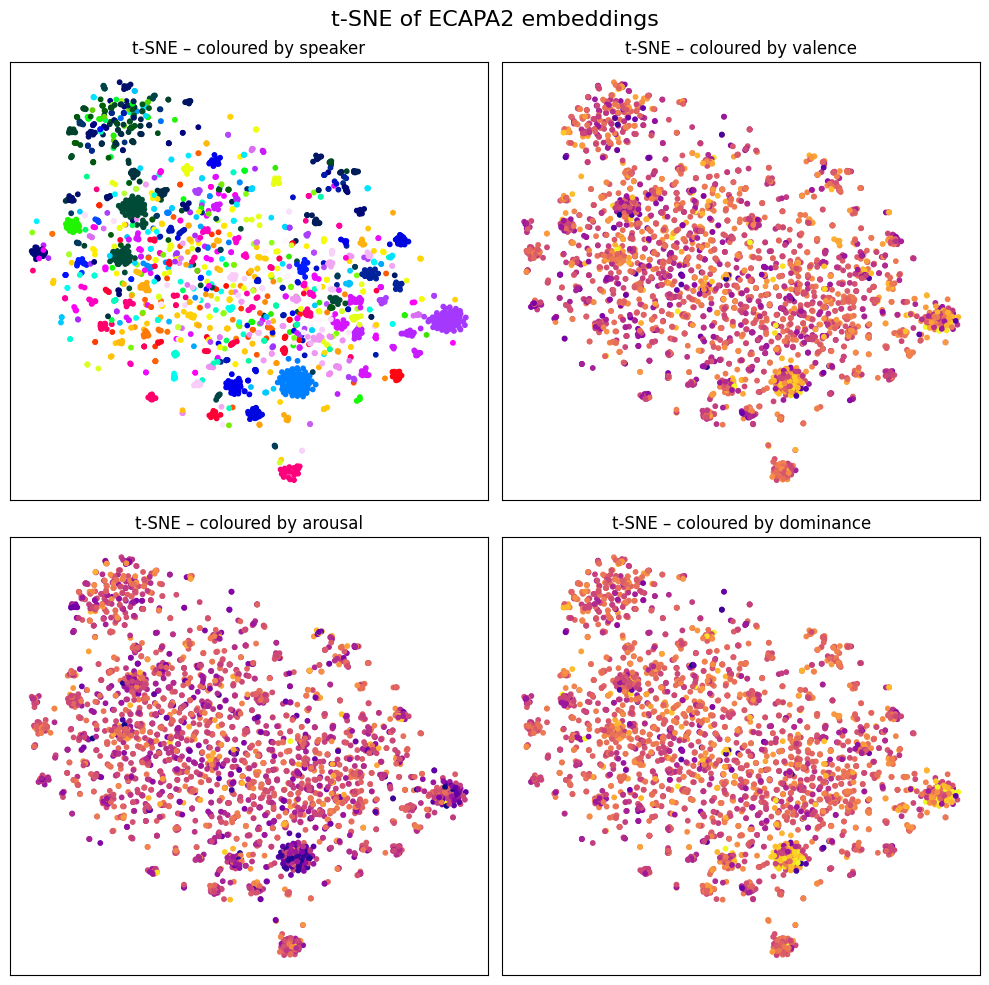

In [9]:
plot_tsne(spk_embeds["ECAPA2"], "ECAPA2")

Silhouette (speaker):           0.08127925
Calinski‑Harabasz (speaker):    4.216675502676974
Davies‑Bouldin  (speaker):      1.271578466850039
ECAPA_TDNN_NEMO (valence): MAE=0.1014 | CCC=0.306 | Pearson r=0.361
ECAPA_TDNN_NEMO (arousal): MAE=0.1040 | CCC=0.284 | Pearson r=0.323
ECAPA_TDNN_NEMO (dominance): MAE=0.0920 | CCC=0.260 | Pearson r=0.307


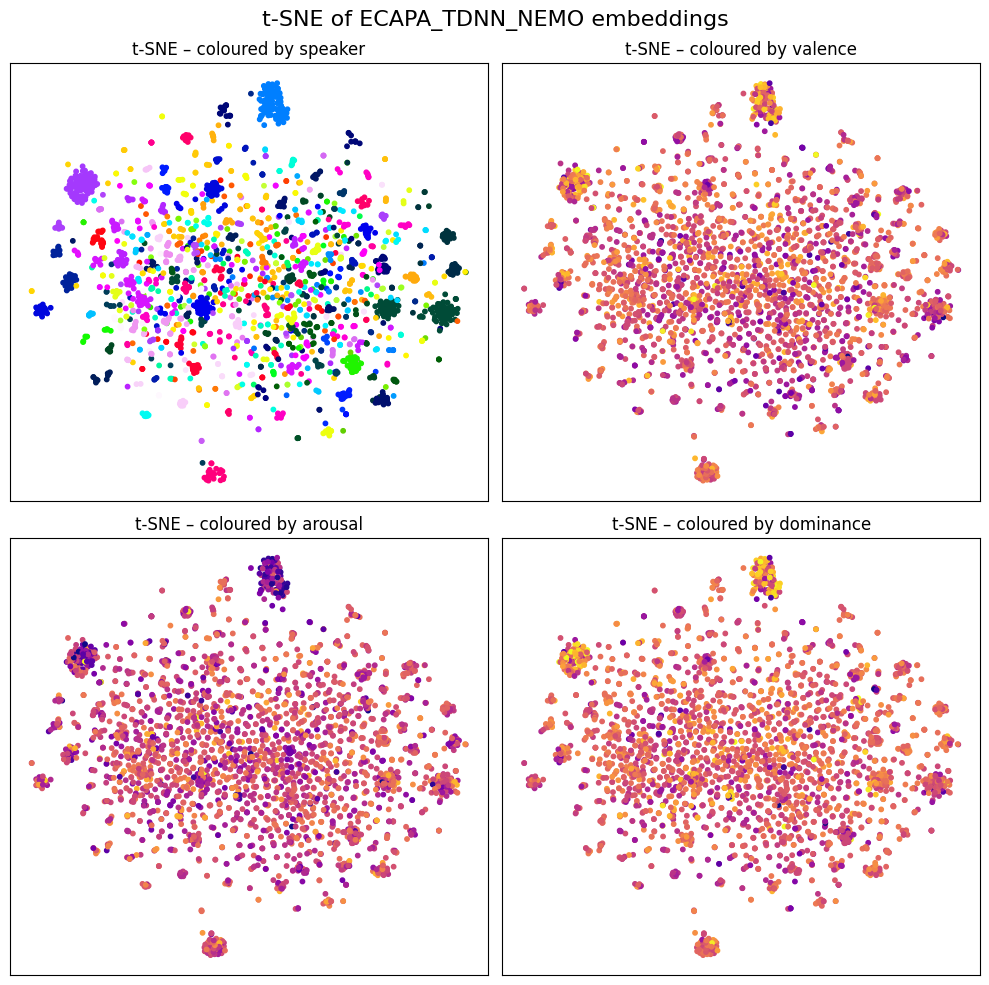

In [10]:
plot_tsne(spk_embeds["ECAPA_TDNN_NEMO"], "ECAPA_TDNN_NEMO")

Silhouette (speaker):           -0.1680941
Calinski‑Harabasz (speaker):    1.4316803245413574
Davies‑Bouldin  (speaker):      2.263761360491705
Wav2Vec2  (valence): MAE=0.0992 | CCC=0.346 | Pearson r=0.409
Wav2Vec2  (arousal): MAE=0.1026 | CCC=0.291 | Pearson r=0.344
Wav2Vec2  (dominance): MAE=0.0917 | CCC=0.262 | Pearson r=0.325


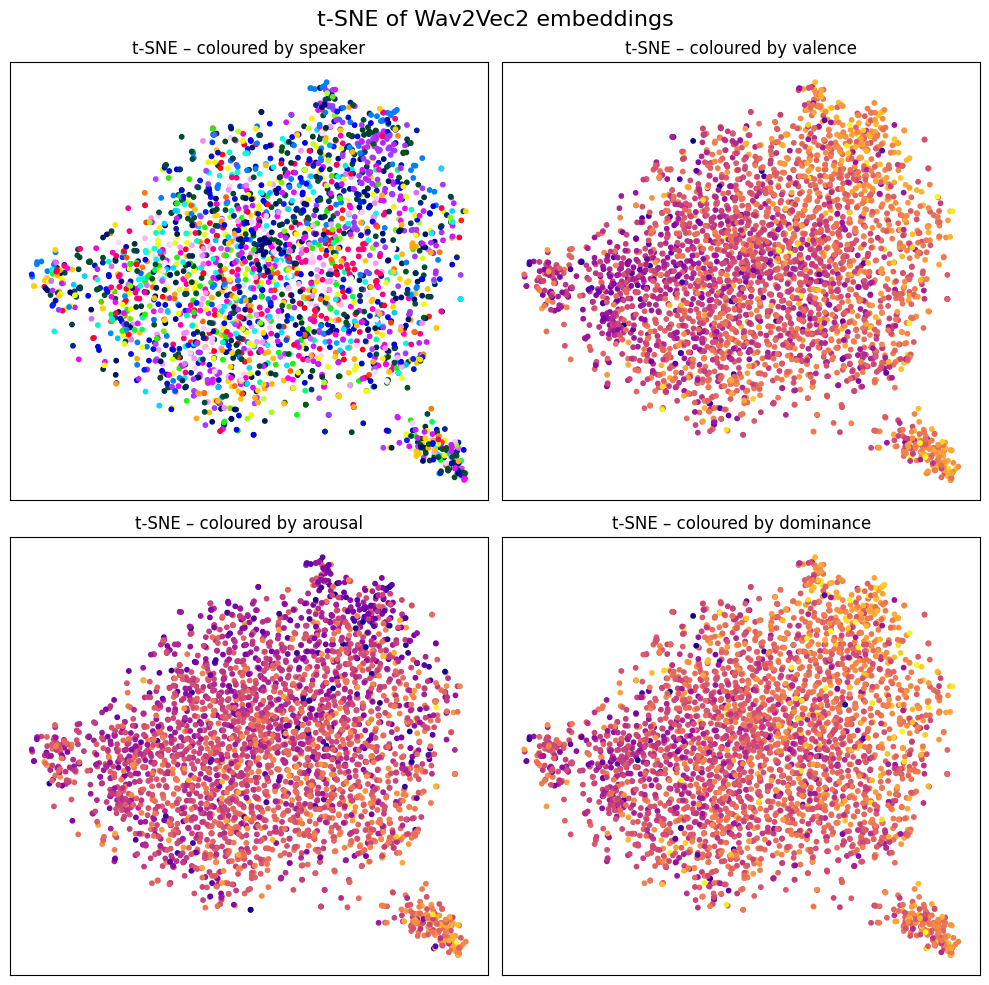

In [11]:
plot_tsne(emo_embeds["Wav2Vec2"], "Wav2Vec2")

Silhouette (speaker):           -0.19268109
Calinski‑Harabasz (speaker):    1.5042684568289106
Davies‑Bouldin  (speaker):      2.46060721243131
WavLM_Odyssey (valence): MAE=0.0959 | CCC=0.437 | Pearson r=0.484
ARI speaker vs valence labels:  0.004944183707075389
WavLM_Odyssey (arousal): MAE=0.1000 | CCC=0.322 | Pearson r=0.376
ARI speaker vs arousal labels:  0.005562130796547722
WavLM_Odyssey (dominance): MAE=0.0895 | CCC=0.356 | Pearson r=0.399
ARI speaker vs dominance labels:  0.0036132578037526507


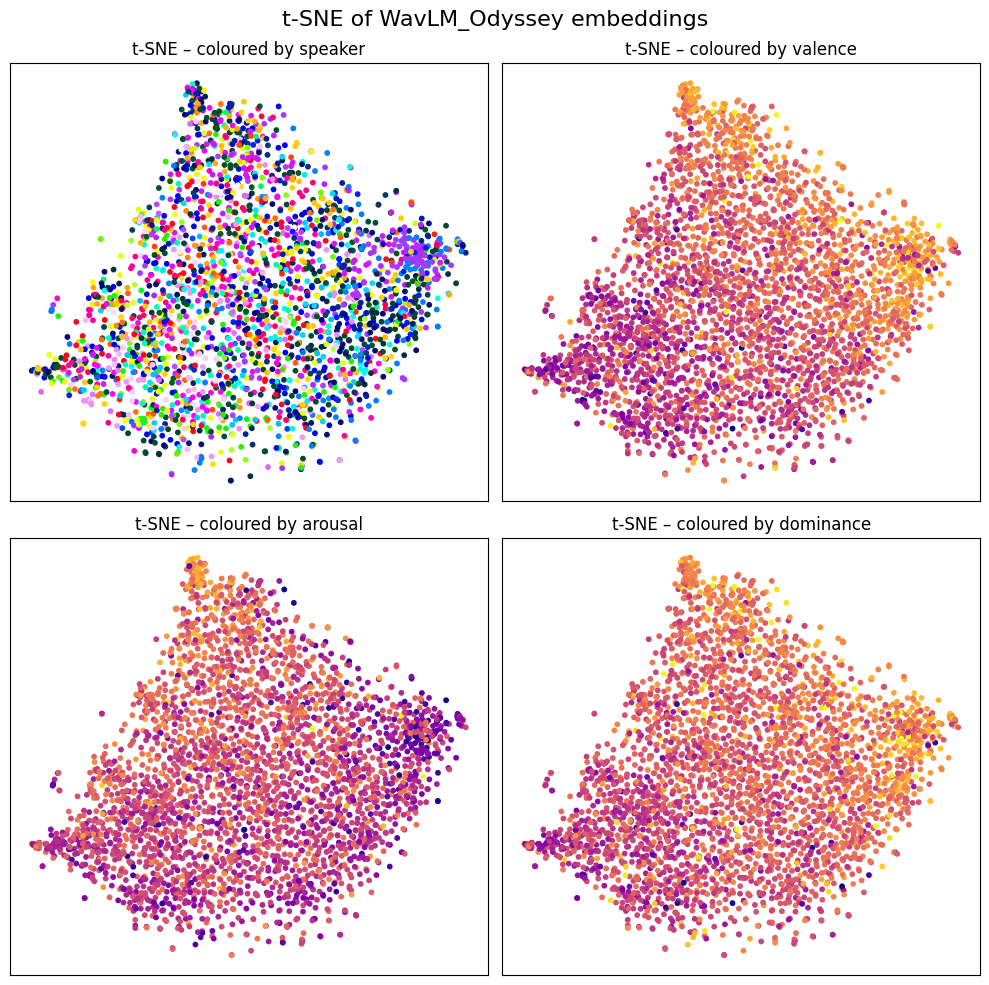

In [15]:
plot_tsne(emo_embeds["WavLM_Odyssey"], "WavLM_Odyssey")